# Yelp Data  - Clustering and PCA



* Clustered text review data, inspect the centroids and find the top ten features for each centroids
* Classified positive and negative reviews with preprocessing PCA, investigate elimination of colinearity using PCA on logistic regression 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

In [4]:
df=pd.read_csv('final_business.csv')

In [3]:
df.head()

,business_id,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2017-02-14,0,VETXTwMw6qxzOVDlXfe6Tg,5,went for dinner tonight. Amazing my husband ha...,0,ymlnR8UeFvB4FZL56tCZsA
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2017-12-04,0,S8-8uZ7fa5YbjnEtaW15ng,5,This was an amazing dinning experience! ORDER ...,0,9pSSL6X6lFpY3FCRLEH3og
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2016-08-22,1,1nK5w0VNfDlnR3bOz13dJQ,5,My husband and I went there for lunch on a Sat...,1,gm8nNoA3uB4In5o_Hxpq3g
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2016-09-13,0,N1Z93BthdJ7FT2p5S22jIA,3,Went for a nice anniversary dinner. Researched...,0,CEtidlXNyQzgJSdF1ubPFw
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Steakhouses, Restaurants, Cajun/Creole",4.0,0,2016-08-08,0,ir-EVhHyWna7KqYWtj660g,5,Hands down the best meal and service I have ev...,0,9_BhDyzJYf2JwTD9TyXJ4g


In [4]:
df.shape

(473382, 12)

## 1. Cluster the review text data for all the restaurants

In [5]:
documents=df['text'].values

In [6]:
documents.shape

(473382,)

### Define  target variable 

In [6]:
# Make a column and take the values, save to a variable named "target"
df['favorable']=(df['stars']>4)
target=df['favorable'].values

### Create training dataset and test dataset

In [7]:
from sklearn.cross_validation import train_test_split

/home/nellieliu0/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
doc_train, doc_test,target_train, target_test=train_test_split(documents, target, test_size=0.8,random_state=2)
# test size is big here due to limited computational capacity

In [11]:
doc_train.shape

(94676,)

In [12]:
target_train.shape

(94676,)

### Get NLP representation of the documents

#### Fit TfidfVectorizer with training data only, then tranform all the data to tf-idf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:

vectorizer=TfidfVectorizer(stop_words='english', max_features=2000)


In [15]:

train_matrix=vectorizer.fit_transform(doc_train).toarray()

In [17]:
train_matrix.shape    #94676 documents each one has 2000 tokens

(94676, 2000)

In [18]:
# Get the vocab of  tfidf
words=vectorizer.get_feature_names()

In [19]:
words[-10:]

['yellow',
 'yellowtail',
 'yelp',
 'yes',
 'yesterday',
 'york',
 'young',
 'yum',
 'yummy',
 'zero']

In [22]:
# Use the trained model to transform all the reviews
doc_matrix=vectorizer.transform(documents).toarray()

In [24]:
documents.shape

(473382,)

In [25]:
doc_matrix.shape

(473382, 2000)

### Cluster reviews with KMeans

#### Fit k-means clustering with the training vectors and apply it on all the data

In [28]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_jobs=-1)
kmeans.fit(train_matrix)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [30]:
kmeans.cluster_centers_.shape   # default is 8 clusters

(8, 2000)

In [33]:
kmeans.labels_[:8]

array([0, 0, 2, 4, 4, 4, 0, 1], dtype=int32)

In [34]:
kmeans.inertia_     # sum of squared distances of samples to their closest cluster center

89105.560117179615

In [37]:
kmeans.score(train_matrix)

-89105.560117179659

#### Make predictions 

In [38]:
assigned_clusters=kmeans.predict(train_matrix)

#### Inspect the centroids

Inspect the centroids to find out what topics each cluster covers. First map these centroids' vectors back to wrod space, regard each dimension of the centroid vector as representing the average review of the words in that cluster.

In [41]:
kmeans.cluster_centers_[0].shape  # just one vector

(2000,)

#### Find the top 10 features for each cluster.

* Sort each centroid vector to find the top 10 features
* Go back to  vectorizer object to find out what words each of these features corresponds to


In [46]:
n_feat=10
top_centroids=kmeans.cluster_centers_.argsort()[:,-1:-n_feat:-1]

In [60]:
top_centroids.shape

(8, 9)

In [47]:
top_centroids[0]

array([1291,  678, 1877,  168,   64,  475, 1003, 1541,  965])

In [51]:
[words[i] for i in top_centroids[0]]

['place',
 'food',
 'vegas',
 'best',
 'amazing',
 'delicious',
 'love',
 'service',
 'like']

In [52]:
",".join(words[i] for i in top_centroids[0])

'place,food,vegas,best,amazing,delicious,love,service,like'

In [54]:
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ",".join(words[i] for i in centroid)))

0: place,food,vegas,best,amazing,delicious,love,service,like
1: food,order,time,minutes,just,service,came,didn,like
2: good,food,really,place,service,nice,pretty,like,great
3: sushi,rolls,place,roll,ayce,great,good,fresh,service
4: great,food,service,place,amazing,friendly,awesome,definitely,staff
5: chicken,fried,rice,food,good,ordered,place,great,sauce
6: burger,fries,burgers,good,shake,cheese,place,food,great
7: pizza,crust,good,place,great,cheese,slice,pepperoni,just


#### Try different k


In [55]:
from sklearn.cluster import KMeans
kmeans_6=KMeans(n_clusters=6,n_jobs=-1)
kmeans_6.fit(train_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [58]:
n_feat

10

In [59]:
kmeans_6.cluster_centers_.shape

(6, 2000)

In [56]:
top_centroids_6=kmeans_6.cluster_centers_.argsort()[:,-1:-n_feat:-1]

In [57]:
top_centroids_6.shape

(6, 9)

In [63]:
for num, centroid in enumerate(top_centroids_6):
    print(num,centroid)

0 [1725 1463 1291 1461  120  756  742  693 1541]
1 [ 742  678 1291 1877  168 1541  475  965   64]
2 [ 316  742 1450  696  678 1381 1291 1196 1768]
3 [ 756  678 1541 1291   64  742  698  473 1655]
4 [1289  443  742 1291  756  307 1587 1258 1785]
5 [ 678 1195 1785 1541  908 1088  263  490  965]


In [62]:
for num, centroid in enumerate(top_centroids_6):
    print ( "%d: %s" % (num, ",".join(words[i] for i in centroid)))

0: sushi,rolls,place,roll,ayce,great,good,fresh,service
1: good,food,place,vegas,best,service,delicious,like,amazing
2: chicken,good,rice,fried,food,ramen,place,ordered,thai
3: great,food,service,place,amazing,good,friendly,definitely,staff
4: pizza,crust,good,place,great,cheese,slice,pepperoni,time
5: food,order,time,service,just,minutes,came,didn,like


### Different k does not give very different results, each category still has pretty much similar topics

In [78]:
np.arange(0, train_matrix.shape[0])[assigned_clusters==0].shape

(37010,)

In [79]:
# there are 37010 documents assigned to cluster0

In [80]:
np.arange(0, train_matrix.shape[0])[assigned_clusters==1].shape

(14786,)

In [82]:
np.arange(0, train_matrix.shape[0])[assigned_clusters==2].shape[0]

13406

In [83]:
cluster_no=[]
for i in range(8):
    cluster_no.append(np.arange(0, train_matrix.shape[0])[assigned_clusters==i].shape[0])

In [84]:
cluster_no   # stores how many documents in each cluster

[37010, 14786, 13406, 3148, 11868, 7650, 3316, 3492]

In [88]:
np.arange(1,9)

array([1, 2, 3, 4, 5, 6, 7, 8])

### I want to check how many data points fall into each cluster and whether that means anyting

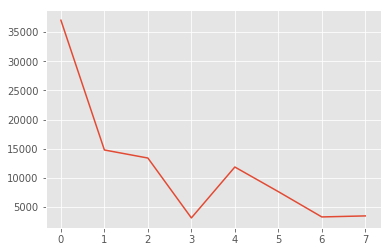

In [90]:
plt.plot(cluster_no)

###
    The third and six seventh clusters has less documents than the rest, I want to take a look at the first and then the thrid and six

In [92]:
cluster_index=np.arange(0, train_matrix.shape[0])[assigned_clusters==0]

In [93]:
cluster_index

array([    0,     1,     6, ..., 94670, 94673, 94675])

In [106]:
rand_index=np.random.choice(cluster_index, 5, replace=False)  # randomly choose two index from cluster index

In [101]:
df.iloc[cluster_index[0]]['stars']

5

In [103]:
df.iloc[cluster_index[0]]['text']

"went for dinner tonight. Amazing my husband had lobster bisque and the T bone both were delish.I had the French onion soup and the pan seared duck. Cooked to perfection and I'm still raving about the flavor. If you are ever in Vegas this is a must try."

In [104]:
df.iloc[cluster_index[1]]['stars']

5

In [105]:
df.iloc[cluster_index[1]]['text']

'This was an amazing dinning experience! ORDER THE PORK CHOP! I will definitely return.'

In [107]:
# this is to show 5 random text and stars from cluster 0
for index in rand_index:
    print(df.iloc[index]['stars'])
    print(df.iloc[index]['text'])

5
I just had to post another review about this place. We love coming here for their coffees and food. A must try is their fresh baked cookies. They run out really fast! Every time we fly back to California, we are cleaning out their almond croissants and chocolate croissants to take to everyone who tried this place out with us. So if it's all sold out, lol sorry it was me! If you like thin crust and crispy pizza, you'll love the pizza here! They give coffee refills if you're dinning in ;) So don't be afraid to ask. All the workers are so nice here so don't forget to leave them a nice tip! They deserve it and the owner himself works as hard to serve everyone too. Hope this was helpful!
5
This is our go to place for breakfast in Vegas. Love the service, love the food! Chill relaxed environment!  Our top pick for breakfast!
5
Great find in the downtown area. Freemont East section in the Container Park. Hot dogs hit the spot. Also have Turkey and Vegan dogs.  Loved it.
5
This has quickly b

### Here I did not find anything particular, imbalanced data points in different clusters might just be a normal thing

###  Now i want to look at the average stars for each cluster, see whether they are very different

In [118]:
df.columns.values

array(['business_id', 'name', 'categories', 'avg_stars', 'cool', 'date',
       'funny', 'review_id', 'stars', 'text', 'useful', 'user_id',
       'favorable'], dtype=object)

In [125]:
#now check out every cluster's average rating

In [127]:
avg_star=[]
for n in range(8):
    cluster_index=np.arange(0, train_matrix.shape[0])[assigned_clusters==n]
    avg_star.append(df.iloc[cluster_index]['stars'].mean())

In [128]:
avg_star

[3.8432585787624967,
 3.8631813877992696,
 3.8440996568700583,
 3.8370393900889455,
 3.8445399393326594,
 3.8444444444444446,
 3.802774427020507,
 3.859106529209622]

### It turns out all cluster has similar average ratings, looks very obvious no need to run ANOVA then

In [111]:
rand_index_3=np.random.choice(cluster_index, 5, replace=False) 

In [113]:
print('reviews from the third cluster with less documents')
for index in rand_index_3:
    print(df.iloc[index]['stars'])
    print(df.iloc[index]['text'])

reviews from the third cluster with less documents
5
Holy crap, this place is great. Here right now, and the service is great. The sushi is amazing. General manager has checked on me twice.  Japanese pickles are great for sharing. Salmon is really buttery, and a deal at $2 each. Egg custard is rich and smooth.
5
Dropped in to try out the Almond coffee milk tea(5/5) and i love it. The drink was sweeten to perfection and the boba was soft and chewy. I will return to try out more flavors.
3
Location was fairly easy. We came here in the evening and parking was jammed pack. Once we walked in, the establishment was nearly empty and a cashier looked tired, yawning at our presence. It was 7:30pm, really?

We were seated and our menu was brought to us. It had no pictures but pictures of the food were on the wall. My parents don't speak or read Chinese or English so it was difficult for them to convey what they wanted to eat. After about 15 minutes, after going through and explaining what was av

In [129]:
# check out the last cluster with less documents in it too

In [130]:
cluster_index_7=np.arange(0, train_matrix.shape[0])[assigned_clusters==7]
rand_index_7=np.random.choice(cluster_index_7, 5, replace=False)

In [131]:
print('reviews from the last cluster with less documents')
for index in rand_index_7:
    print(df.iloc[index]['stars'])
    print(df.iloc[index]['text'])

reviews from the last cluster with less documents
3
The spicy chicken waffle sandwich wasn't very spicy. So that was a bummer but the flavor was good.

I think I'm being picky because I've had better fried chicken. Buuut, I will say that the waffle was pretty delicious. Perfect crispy texture on the outside while having that thin light fluffy interior you expect from waffles on the inside.

They have their waffles DOWN. The fried chicken is just not the best that I've had.

I will say though, I love the concept of the restaurant. Waffle sandwiches stuffed with fried chicken? What's not to love?

This place isn't perfect. It's not the best sandwich I've ever hand. It's not a sandwich that I couldn't dare to dream without. But you can't really go wrong with a fried chicken/waffle pairing and this place does it pretty well.

3 stars because I wouldn't really go out of my way to come here. But if you were in the area, it wouldn't be a bad choice for a meal.
5
O.M.G! This place is so good! 

### 
    From the cluster centroid and examples, i feel like each cluster is focusing on different perspective: one cluster mainly about food, others maybe about service, enviornment, since these aspects are major ones that people care about,  yelp may design review systems to let user explicitly rate these aspects so that restaurants owns can see and improve in certain ways

## 2. Cluster all the reviews of the most reviewed restaurant
find the most reviewed restaurant and analyze its reviews

In [3]:
most_reviews=df['business_id'].value_counts().index[0]

In [4]:
df_top=df[df['business_id']==most_reviews].copy()

In [148]:
df_top.shape

(3465, 13)

### Vectorize the text feature

In [5]:
documents_top=df_top['text'].values

In [151]:
documents_top.shape

(3465,)

### Define  target variable 

In [6]:
df_top['fav'] = (df_top['stars'] > 4)
target_top=df_top['fav'].values.astype(int)


### Create training dataset and test dataset

In [9]:
from sklearn.cross_validation import train_test_split

/home/nellieliu0/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# documents_top_restaurant is your X, target_top_restaurant is your y
# Now split the data to training set and test set
# Now your data is smaller, you can use a typical "test_size", e.g. 0.3-0.7
X_train, X_test, y_train, y_test = train_test_split(
    documents_top, target_top, test_size=0.40, random_state=42)

In [158]:
X_train.shape

(2079,)

In [159]:
X_train[:3]

array([ 'Terrible queuing system. Wait to get into another line to wait to sit down. 1 hour wait to get in line to pay, 20 minutes to then pay, and an additional hour after paying to get seated. A lot of people were cutting in line at the "6 or more persons" line and the workers not even stopping them. Very disorganized. Will not be coming back.',
       'Overrated! The meat selection was great until we realized everything was rare-medium. My party prefer our cows all the way cooked. Food was cold, selection as ok, just not worth the 65.00 we paid.',
       "If you have only ever been to a strip-mall meatloaf and mashed potatoes buffet, this is going to blow your mind!  If you've had brunch at s fancy hotel, this will disappoint.  It's all a matter of perspective.\n\nFood:  \nPros: variety & presentation.  \nCons: taste and quality.  We walked in with high expectations because of all the glowing reviews and we walked out disappointed and a little hungry.  \n\nThe bad:\nCrab: terrible q

### Get NLP representation of the documents

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer=TfidfVectorizer(stop_words='english', max_features=1000)
train_top_matrix=vectorizer.fit_transform(X_train).toarray()



In [161]:
type(vectorizer.fit_transform(X_train))

scipy.sparse.csr.csr_matrix

In [13]:
# Get the vocab of your tfidf
words_top=vectorizer.get_feature_names()

In [164]:
len(words_top)

1000

In [166]:
words_top[-10:]

['wouldn',
 'wow',
 'wrong',
 'wynn',
 'year',
 'years',
 'yelp',
 'yes',
 'yum',
 'yummy']

In [14]:

test_top_matrix=vectorizer.transform(X_test).toarray()

In [15]:

doc_top_matrix=vectorizer.transform(documents_top)

In [16]:
doc_top_matrix.shape

(3465, 1000)

### Cluster reviews with KMeans

#### Fit k-means clustering on the training vectors and make predictions on all data

In [170]:
kmeans_top = KMeans(n_clusters=5)

kmeans_top.fit(train_top_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [207]:
y_kmeans=kmeans_top.predict(train_top_matrix)

In [212]:
y_kmeans.shape

(2079,)

#### Make predictions 

In [172]:
assigned_top=kmeans_top.predict(doc_top_matrix)

In [174]:
assigned_top.shape

(3465,)

#### Inspect the centroids

In [178]:
# To be implemented
print ("cluster centers:")
print (kmeans_top.cluster_centers_.shape)


cluster centers:
(5, 1000)


In [206]:
train_top_matrix.shape

(2079, 1000)

In [204]:
train_top_matrix[:,0].shape

(2079,)

In [205]:
train_top_matrix[:,1].shape

(2079,)

#### Find the top 10 features for each cluster.


* sort each centroid vector to find the top 10 features
* go back to  vectorizer object to find out what words each ofthese corresponds to 

In [188]:
n_feat=10
top_centroids_top=kmeans_top.cluster_centers_.argsort()[:,-1:10:-1]

In [190]:
top_centroids1=kmeans_top.cluster_centers_.argsort()[:,-1:-n_feat:-1]

In [191]:
top_centroids1.shape

(5, 9)

In [193]:
print ("top features for each cluster:")

for num, centroid in enumerate(top_centroids1):
    print("%d: %s " % (num, ",". join(words[i] for i in centroid)))

top features for each cluster:
0: booth,attentive,day,chip,coast,grab,hip,browns,greek 
1: chip,coast,fare,attentive,crew,italian,fremont,locations,decide 
2: attentive,apology,large,chip,attitude,flavors,cuts,amazing,ladies 
3: coke,groupon,chip,greet,attentive,brisket,added,ground,coast 
4: deep,leaves,desert,italian,chip,corn,attentive,cocktail,locations 


In [196]:
train_top_matrix.shape[0]

2079

In [ ]:
X_train.sha

In [197]:
cluster_no=[]
for i in range(5):
    cluster_no.append(np.arange(0, doc_top_matrix.shape[0])[assigned_top==i].shape[0])

In [198]:
cluster_no

[936, 1068, 580, 382, 499]

### now print out the rating and review of a random sample of the reviews assigned to each cluster to get a sense of the cluster

In [202]:
for i in range(kmeans_top.n_clusters):
    cluster=np.arange(0,doc_top_matrix.shape[0])[assigned_top==i]
    sample_reviews=np.random.choice(cluster,2,replace=False)
    print("="*10)
    print("Cluster %d:" % i)
    for review_index in sample_reviews:
        print ("         %s - " % df.loc[review_index]['stars'], "%s" % df.loc[review_index]['text'])
    print

Cluster 0:
         4 -  The husband took me here for my birthday and we both enjoyed the entertainment and food.  We loved everything about this place. The restaurant was very cozy and intimate. They even pour rose water over your hands so you can wash them at your table.  The experience itself was hands down amazing!

Now you gotta come here HUNGRY cause they do offer a 6 course meal (yes 6 courses) and I must say, by the time we got to the main course we were FULL. Probably our fault since we loaded on the Morroccan bread ;) But that bread dipped in the shrimp scampi sauce...heaven!  I especially loved their hummus and babaganoush plate. If you're like me and love roasted eggplant, you'll love the babaganoush - it was packed with so much flavor! The beef kabobs were so yummy that I wished they offered more especially since I thought that was the main course, but I was wrong. The main course came after and honestly, we were already stuffed we just couldn't eat anymore. Which was okay

## 3. Use PCA to reduce dimensionality

### Stardardize features
Your X_train and X_test

In [38]:
from scipy import stats


DescribeResult(nobs=2079, minmax=(0.0, 0.88570899602307451), mean=0.0095386244281801379, variance=0.0018307589929981458, skewness=8.186743127856888, kurtosis=111.34845760725852)

In [41]:
train_top_matrix.shape

(2079, 1000)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(train_top_matrix)
X_test_scaled=scaler.transform(test_top_matrix)



In [39]:
type(X_train_scaled)

numpy.ndarray

In [42]:
stats.describe(X_train_scaled[:,1])

DescribeResult(nobs=2079, minmax=(-0.22298447878256494, 20.482239877022661), mean=-4.6139138685720794e-17, variance=1.0004812319538137, skewness=8.18674312785689, kurtosis=111.34845760725855)

In [40]:
X_train_scaled.shape

(2079, 1000)

### Use PCA to transform data (train and test) and get princial components

In [43]:
from sklearn.decomposition import PCA

# Let's pick a n_components
n_components = 50

pca=PCA(n_components=n_components)
X_train_pca=pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [44]:
X_train_pca.shape   #now dimension decreased

(2079, 50)

In [45]:
X_test_pca.shape

(1386, 50)

In [48]:
pca.explained_variance_

array([ 8.59700134,  5.78056238,  4.64706691,  4.20859929,  3.89036813,
        3.73327477,  3.52418338,  3.39171692,  3.34774061,  3.28399906,
        3.16455517,  3.13471438,  3.07705202,  3.02153295,  2.98418179,
        2.93629202,  2.90619051,  2.85082863,  2.84018579,  2.81059641,
        2.79105212,  2.75692165,  2.71276081,  2.69267476,  2.6798773 ,
        2.65578781,  2.63249111,  2.61885412,  2.61167083,  2.59769795,
        2.56974726,  2.55980913,  2.54006682,  2.51826653,  2.50991904,
        2.50357465,  2.49019086,  2.45204015,  2.43499975,  2.42436873,
        2.3915316 ,  2.37522538,  2.37229085,  2.36425077,  2.35614017,
        2.32529147,  2.3190112 ,  2.30930323,  2.30125589,  2.29496438])

In [49]:
pca.explained_variance_ratio_[:10]

array([ 0.00859287,  0.00577778,  0.00464483,  0.00420657,  0.0038885 ,
        0.00373148,  0.00352249,  0.00339009,  0.00334613,  0.00328242])

### Viz: plot proportion of variance explained with top principal components

For clear display, you may start with plotting <=20 principal components

Text(0,0.5,'Variance Explained')

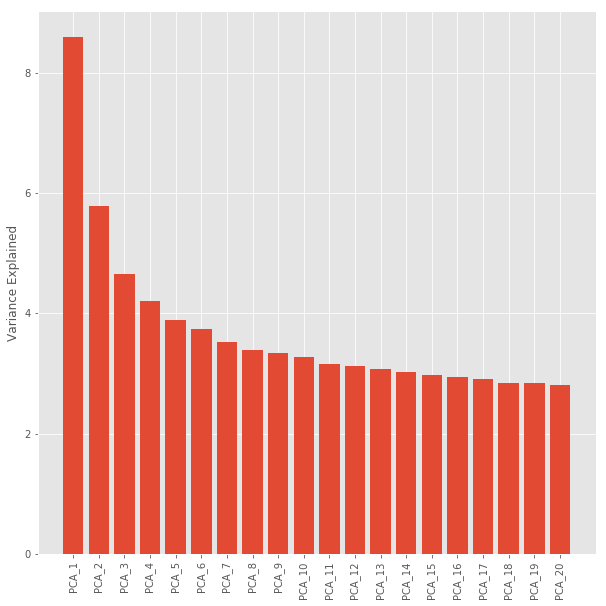

In [52]:
n_col_to_display=20

pca_range=np.arange(n_col_to_display)+1
pca_names=['PCA_%s' % i for i in pca_range]

plt.figure(figsize=(10,10))
plt.bar(pca_range,pca.explained_variance_[:n_col_to_display],align='center')
xticks=plt.xticks(pca_range,pca_names, rotation=90)
plt.ylabel('Variance Explained')

In [ ]:
#usually use elbow point to pick the number of pca components

In [ ]:
# but as this is a NLP problem, if pick only top ones, maybe too many repetitive words
#better use all components

## Classifying positive/negative review with PCA preprocessing

### Logistic Regression Classifier
#### Use standardized tf-idf vectors as features

In [53]:
# Build a Logistic Regression Classifier, train with standardized tf-idf vectors

from sklearn.linear_model import LogisticRegression

clt_lr=LogisticRegression()
clt_lr.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
clt_lr.score(X_train_scaled,y_train)

0.99903799903799906

In [55]:
clt_lr.score(X_test_scaled,y_test)

0.72294372294372289

* training score is  much higher than test score, it is overfitting
*  here used 1000 features, original data

#### Use (Stardardized + PCA) tf-idf vectors as features

In [56]:
# Build a Logistic Regression Classifier, train with PCA tranformed X

from sklearn.linear_model import LogisticRegression
clt_lr_pca=LogisticRegression()
clt_lr_pca.fit(X_train_pca,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
# Get score for training set
clt_lr_pca.score(X_train_pca,y_train)

0.79797979797979801

In [59]:
# Get score for test set, REMEMBER to use PCA-transformed X!
clt_lr_pca.score(X_test_pca,y_test)

0.77561327561327564

* training 0.79, test: 0.77 now overfitting is gone, feature dimension decreased from 1000 to 50
* I think PCA helps to eliminate some colinearity which helps with overfitting problem
* but overfitting is not the only reason cause training score different from test score
* the difference on the socre could also highly depends on the similarity between train and test datast

#### Plot the coefficients against principal components


In [60]:
pca.n_components_

50

In [62]:
# To be implemented
pca_range=np.arange(pca.n_components_)+1
pca_names=['PC_%s' % i for i in pca_range]

df_coeffs=pd.DataFrame(list(zip(pca_names, clt_lr_pca.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns=['PCs','coeff']
df_coeffs

,PCs,coeff
2,PC_3,0.565236
3,PC_4,0.301928
9,PC_10,0.236414
11,PC_12,0.217694
15,PC_16,0.178839
5,PC_6,0.154962
12,PC_13,0.127114
18,PC_19,0.123336
23,PC_24,0.078637
35,PC_36,0.072205


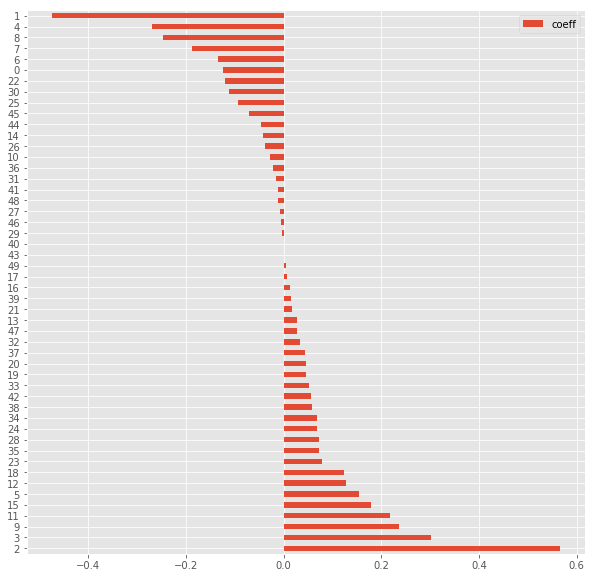

In [65]:
ax=df_coeffs.plot.barh(figsize=(10,10))
t=np.arange(pca.n_components_)
ax.set_yticks(t)
#ax.set_yticks(df_coeffs['PCs'])
plt.show()


### Random Forest Classifier
#### Use standardized tf-idf vectors as features

In [66]:
# Build a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

clt_rf=RandomForestClassifier(n_estimators=20, min_samples_split=3, n_jobs=-1, random_state=2)
clt_rf.fit(X_train_scaled,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [67]:
# Get score for training set
clt_rf.score(X_train_scaled,y_train)

0.99615199615199612

In [68]:
# Get score for test set
clt_rf.score(X_test_scaled,y_test)

0.74963924963924966

In [ ]:
#training score> testing  logistic regression more prone to overfitting due to multicolinearity

#### Use (Stardardized + PCA) tf-idf vectors as features

In [69]:
# Build a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
clt_rf=RandomForestClassifier(n_estimators=20, min_samples_split=3, n_jobs=-1, random_state=2)
clt_rf.fit(X_train_pca,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [70]:
# Get score for training set
clt_rf.score(X_train_pca,y_train)

0.99663299663299665

In [71]:
clt_rf.score(X_test_pca,y_test)

0.72510822510822515

In [ ]:
# now traing and testing score should not be that different

## Cluster restaurants from their category information


In [73]:
df.columns.values

array(['business_id', 'name', 'categories', 'avg_stars', 'cool', 'date',
       'funny', 'review_id', 'stars', 'text', 'useful', 'user_id'], dtype=object)

In [8]:
df.shape

(473382, 13)

In [9]:
df['categories'][:3]

0    Steakhouses, Restaurants, Cajun/Creole
1    Steakhouses, Restaurants, Cajun/Creole
2    Steakhouses, Restaurants, Cajun/Creole
Name: categories, dtype: object

In [14]:
df['categories'].unique().shape

(3321,)

In [10]:
documents=df['categories'].values

In [12]:
documents[-3:]

array([ 'Food, Acai Bowls, Restaurants, Coffee & Tea, Tea Rooms, Creperies, Juice Bars & Smoothies, Desserts',
       'Food, Acai Bowls, Restaurants, Coffee & Tea, Tea Rooms, Creperies, Juice Bars & Smoothies, Desserts',
       'Food, Acai Bowls, Restaurants, Coffee & Tea, Tea Rooms, Creperies, Juice Bars & Smoothies, Desserts'], dtype=object)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    documents, target, test_size=0.40, random_state=2)

In [16]:
#use tfidvectorizer to transform data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(stop_words = 'english', max_features = 1000)
vectors_train = vectorizer.fit_transform(X_train).toarray()

words=vectorizer.get_feature_names()

doc_matrix=vectorizer.transform(documents).toarray()

In [17]:
doc_matrix.shape

(473382, 485)

In [20]:
len(words)

485

In [ ]:
# there are less than 1000 words

In [19]:
documents.shape

(473382,)

In [23]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_jobs=-1)
kmeans.fit(doc_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
# find the top 10 features for each cluster

In [24]:
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-11:-1]
print("top 10 features for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(words[i] for i in centroid)))

top 10 features for each cluster:
0: breakfast, brunch, american, traditional, restaurants, sandwiches, new, burgers, buffets, diners
1: japanese, sushi, bars, restaurants, fusion, asian, ramen, noodles, seafood, tapas
2: mexican, restaurants, tacos, nightlife, fast, bars, food, mex, tex, brunch
3: bars, nightlife, american, wine, restaurants, new, cocktail, traditional, sports, beer
4: pizza, italian, restaurants, sandwiches, salad, wings, chicken, seafood, food, american
5: food, fast, event, restaurants, services, planning, burgers, specialty, caterers, sandwiches
6: restaurants, american, chinese, new, traditional, steakhouses, seafood, buffets, thai, burgers
7: tea, coffee, food, cafes, brunch, breakfast, restaurants, desserts, bubble, bakeries


###  Here i think  clusters are more distinct from each other. for example, cluster 0 is more American traditional food including breakfast and brunch, and cluster 1 is Japanese/Asian type, cluster 2 is mexicanmex/tex... each one is very unique from the rest. But this is expected, since the catgory column already has summarized information compared with the reviews